
SSO STATION KEEPING


- Burning time = 9469.99108982068 s
- Delta V = 0.022727978615569633

Process finished --- 175 seconds
Timestep 1500.7444 ss
Run time 175.44s/2.92m


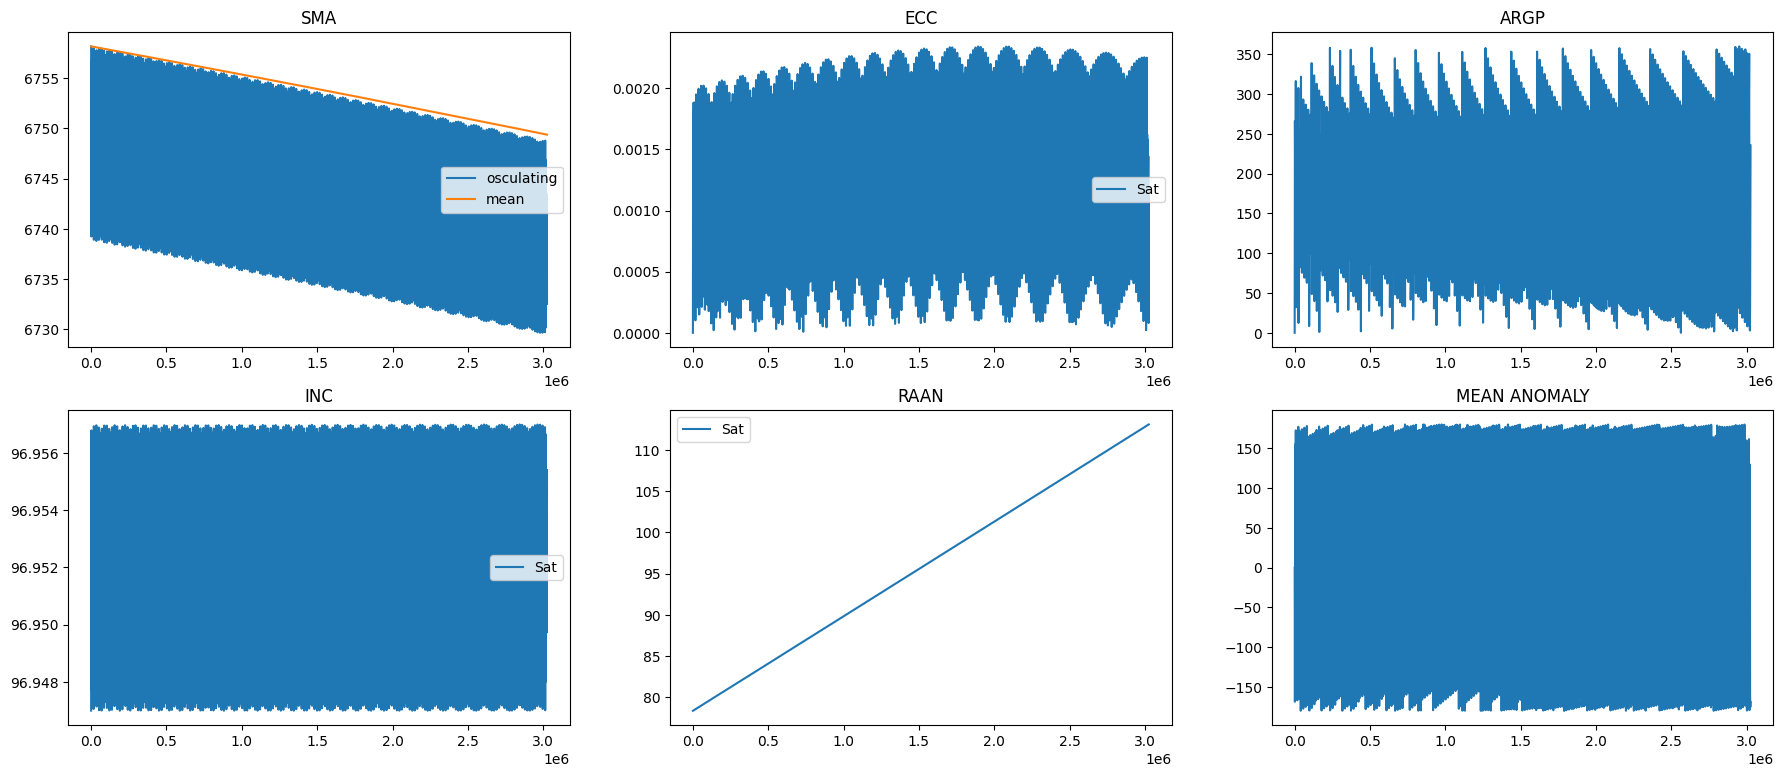

In [7]:
# SPACECRAFT THRUST

from astropy import units as u
from astropy.time import Time, TimeDelta

from poliastro.bodies import Earth
from poliastro.constants import rho0_earth, H0_earth
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import CowellPropagator
from poliastro.twobody.thrust import change_a_inc
from poliastro.core.perturbations import J2_perturbation, atmospheric_drag_exponential
from poliastro.core.propagation import func_twobody 
from poliastro.util import Time
#from poliastro.plotting import OrbitPlotter2D

from datetime import datetime, timedelta

from numba import njit as jit

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import time

from sso_inc_sk import inc_from_alt, raan_from_ltan
from perturbations_sk import coesa76_model

print('\nSSO STATION KEEPING\n')

toc = time.time()

process_start_time = time.time()   # start time of python code


# Constants
R = Earth.R.to(u.km).value
k = Earth.k.to(u.km**3 / u.s**2)
k_val = k.value
J2 = Earth.J2.value

rho0 = rho0_earth.to(u.kg/u.km**3).value
H0   = H0_earth.to(u.km).value

# GMAT correct RHW orbit decay was for: C_D = 2.2, A = 0.02 m^2, m = 2.205 kg
C_D = 2.2
A_over_m = ((0.01 * u.m**2) / (2.5 * u.kg)).to_value(u.km**2 / u.kg)   # km**2/kg
B = C_D * A_over_m   # ballistic coefficient at low drag mode

# Definition of the initial orbit (poliastro)
start_date = datetime(2024,1,1,9,0,0)
ltan = 22.5

a = (R + 380) << u.km
ecc = 1e-6 << u.one
inc = inc_from_alt(380,ecc)[0] << u.deg   
raan = raan_from_ltan(Time(val=datetime.timestamp(start_date), format='unix'),ltan) << u.deg
argp = 1e-6 << u.deg
nu = 1e-6 << u.deg

epoch = Time(val=start_date.isoformat(), format='isot')

start_date_ts = datetime.timestamp(start_date)
stop_date_ts = datetime.timestamp(start_date + timedelta(hours = 24*7*5))
sample_num = 9*1*16*7*2
timestamps = np.linspace(start_date_ts, stop_date_ts, sample_num)
time_step = (timestamps[1]-timestamps[0]) << u.s

in_orbit = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu, epoch)

a_list     = [in_orbit.a.value]
a_mean_list = [in_orbit.a.value]
ecc_list   = [in_orbit.ecc.value]
inc_list   = [in_orbit.inc.value]
raan_list  = [in_orbit.raan.value]
argp_list  = [in_orbit.argp.value]
nu_list    = [in_orbit.nu.value]
epoch_list = [in_orbit.epoch.value]

secs = 0
elapsedsecs = [0]

a_up   = (R + 400) * u.km
a_down = (R + 360)  * u.km 
acc = 2.4e-6 * (u.km / u.s**2)


def a_d(t0, state, k, J2, R, C_D, A_over_m):

    return J2_perturbation(
        t0, state, k, J2, R
        ) + coesa76_model(
            state, R, C_D, A_over_m
            )

def a_d_mean(state, R, C_D, A_over_m):

    return coesa76_model(
            state, R, C_D, A_over_m
            )

a_d_thrust, deltaV, t_f = change_a_inc(k, a_down, a_up, inc, inc, acc)

def f_thrust(t0, state, k):

    du_kep = func_twobody(t0, state, k)
    ax, ay, az = a_d(
        t0, 
        state, 
        k=k_val,
        J2=J2, 
        R = R, 
        C_D = C_D, 
        A_over_m = A_over_m
        )
    
    ax_t, ay_t, az_t = a_d_thrust(t0,
                                  state,
                                  k=k)
    
    du_ad = np.array([0, 0, 0, ax+ax_t, ay+ay_t, az+az_t])

    return du_kep + du_ad

def f_thrust_mean(t0, state, k):

    du_kep = func_twobody(t0, state, k)
    ax, ay, az = a_d_mean(
        state, 
        R = R, 
        C_D = C_D, 
        A_over_m = A_over_m
        )
    
    ax_t, ay_t, az_t = a_d_thrust(t0,
                                  state,
                                  k=k)
    
    du_ad = np.array([0, 0, 0, ax+ax_t, ay+ay_t, az+az_t])

    return du_kep + du_ad

def f_no_thrust(t0, state, k):

    du_kep = func_twobody(t0, state, k)
    ax, ay, az = a_d(
        t0, 
        state, 
        k=k_val,
        J2=J2, 
        R = R, 
        C_D = C_D, 
        A_over_m = A_over_m
        )
    
    du_ad = np.array([0, 0, 0, ax, ay, az])

    return du_kep + du_ad

def f_no_thrust_mean(t0, state, k):

    du_kep = func_twobody(t0, state, k)
    ax, ay, az = a_d_mean(
        state,  
        R = R, 
        C_D = C_D, 
        A_over_m = A_over_m
        )
    
    du_ad = np.array([0, 0, 0, ax, ay, az])

    return du_kep + du_ad

sat_orbit = in_orbit
mean_orbit = in_orbit

for timestamp in range(len(timestamps)):
    secs += time_step.value
    if  mean_orbit.a.value > a_down.value:
        sat_orbit  = sat_orbit.propagate(time_step,method=CowellPropagator(rtol=1e-5, f=f_no_thrust))
        mean_orbit = mean_orbit.propagate(time_step,method=CowellPropagator(rtol=1e-5, f=f_no_thrust_mean))
    else:
        sat_orbit = sat_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=f_thrust))
        mean_orbit = mean_orbit.propagate(time_step,method=CowellPropagator(rtol=1e-5, f=f_thrust_mean))

    elapsedsecs.append(secs)

    a_list.append(sat_orbit.a.value)
    a_mean_list.append(mean_orbit.a.value)
    ecc_list.append(sat_orbit.ecc.value)
    inc_list.append(sat_orbit.inc.to_value(u.deg))
    raan_list.append(sat_orbit.raan.to_value(u.deg))
    argp_list.append(sat_orbit.argp.to_value(u.deg))
    nu_list.append(sat_orbit.nu.to_value(u.deg))

# Orbital elements data
# data_table = zip(epoch_list, a_list, ecc_list, inc_list, raan_list, argp_list, nu_list)
# df = pd.DataFrame(data = data_table, columns= ['Epoch [UTC]', 'SMA [Km]', 'ECC', 'INC [deg]', 'RAAN [deg]', 'ARGP [deg]', 'TA [deg]'])
# print(df)

# # Data to .txt file
# path = r'C:\Users\Lorenzo\Documents\GitHub\gmat_lorenzo\my_scripts\keplerian_propagator\rhw_1week.txt'

# with open(path, 'a') as f:
#     df_string = df.to_string()
#     f.write(df_string)

print(f'\n- Burning time = {t_f}\n- Delta V = {deltaV}')
print(f'\nProcess finished --- {int(time.time() - process_start_time)} seconds')

fig, ax = plt.subplots(2, 3, figsize=(22,9), squeeze=False) 

ax[0,0].plot(elapsedsecs, a_list, label='osculating')
ax[0,0].plot(elapsedsecs, a_mean_list, label='mean')
ax[0,0].legend(loc = 'center right')
ax[0,0].set_title('SMA')

ax[0,1].plot(elapsedsecs, ecc_list, label='Sat')
ax[0,1].legend(loc = 'center right')
ax[0,1].set_title('ECC')

ax[1,0].plot(elapsedsecs, inc_list, label='Sat')
ax[1,0].legend(loc = 'center right')
ax[1,0].set_title('INC')

ax[1,1].plot(elapsedsecs, raan_list, label='Sat')
ax[1,1].legend(loc = 'upper left')
ax[1,1].set_title('RAAN')

ax[0,2].plot(elapsedsecs,argp_list, label='Sat')
ax[0,2].set_title('ARGP')

ax[1,2].plot(elapsedsecs, nu_list, label='Sat')
ax[1,2].set_title('MEAN ANOMALY')

# plt.show(block=True)

tic = time.time()
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
plt.show()